In [1]:
# import modules and packages
from pathlib import Path
import random
import numpy as np

import torch
import torch.optim as optim

from foe_fingerprint_dataset import FOEFingerprintDataset
from foe_orientation import FOEOrientation
from foe_results import FOEResults
from functions import (create_dataloaders, init_model, train_epoch, val_epoch,
                       save_model)

# from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'widget')


def angle_loss(y, ye):
    delta_sqr = [torch.min(torch.abs(yi-yei), np.pi-torch.abs(yi-yei))
                 for (yi, yei) in zip(y, ye)]
    return torch.mean(torch.stack(delta_sqr))

In [2]:
# parameters
# dataset_dir = '../datasets/Finger/FOESamples'
# output_dir = '../results'
# use_cpu = False
# seed = 0
# split_id = 2
# num_folds = 5

# patch_size = 64
# batch_size = 64
# hflip = True
# rotate = True

# num_classes = 36
# num_epochs = 100
# learning_rate = 0.0001
# approach = 'ae_mlp'

# encoded_space_dim = 512
# train_with_bad = True
# ae_num_epochs = 300
# ae_learning_rate = 0.1
# file_id = 'default_file_id'

dataset_dir = ''
output_dir = ''
use_cpu = ''
seed = ''
split_id = ''
num_folds = ''

patch_size = ''
batch_size = ''
hflip = ''
rotate = ''

num_classes = ''
num_epochs = ''
learning_rate = ''
approach = ''

encoded_space_dim = ''
train_with_bad = ''
ae_num_epochs = ''
ae_learning_rate = ''
file_id = ''

In [3]:
# Parameters
dataset_dir = "../datasets/Finger/FOESamples"
output_dir = "../results"
use_cpu = False
seed = 0
split_id = 2
num_folds = 5
approach = "cnn"
batch_size = 64
hflip = True
rotate = True
num_epochs = 100
learning_rate = 0.001
num_classes = 9
patch_size = 96
file_id = "e1d3eefedd01a0383c6c5547367e178d"


In [4]:
# parse and configure the experiment parameters
args = dict(((k, eval(k)) for k in ('patch_size', 'batch_size', 'hflip',
                                    'rotate', 'num_classes', 'num_epochs',
                                    'learning_rate', 'approach',
                                    'encoded_space_dim', 'train_with_bad',
                                    'ae_num_epochs', 'ae_learning_rate')))
print(args)

dataset_dir = Path(dataset_dir)
output_dir = Path(output_dir)

models_dir = output_dir.joinpath('models')
splits_dir = output_dir.joinpath('splits')
logs_dir = output_dir.joinpath('logs')
results_dir = output_dir.joinpath('results')

output_dir.mkdir(parents=True, exist_ok=True)
models_dir.mkdir(parents=True, exist_ok=True)
splits_dir.mkdir(parents=True, exist_ok=True)
logs_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

use_gpu = torch.cuda.is_available() and not use_cpu
device = 'cuda' if use_gpu else 'cpu'

print('Using {}...'.format(device))
print('Patch size: {}'.format(patch_size))
print('Batch size: {}'.format(batch_size))

if seed is not None:
    seed = int(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    # torch.set_deterministic(True)

NUM_WORKERS = 4

{'patch_size': 96, 'batch_size': 64, 'hflip': True, 'rotate': True, 'num_classes': 9, 'num_epochs': 100, 'learning_rate': 0.001, 'approach': 'cnn', 'encoded_space_dim': '', 'train_with_bad': '', 'ae_num_epochs': '', 'ae_learning_rate': ''}
Using cuda...
Patch size: 96
Batch size: 64


Split indices with id 2 loaded. Number of folds ignored.
Split indices with id 2 loaded. Number of folds ignored.
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Experiments for fold 0 starts...


Training and validating with:
        Autoencoder training set size: 15950
        Orientation estimation training set size: 76728
        Validation set size (good): 2996
        Validation set size (bad): 15034


EPOCH 1/100	LOSS for train/good val/bad val:	0.947 / 0.888 / 0.508 / 0.964


RMSE for good train/bad train good val/bad val:		9.7° / 20.1° / 7.0° / 20.0°


ACC for good train/bad train good val/bad val:		77.1% / 62.2% / 78.2% / 62.6%


EPOCH 2/100	LOSS for train/good val/bad val:	0.742 / 0.707 / 0.394 / 0.769


EPOCH 3/100	LOSS for train/good val/bad val:	0.701 / 0.697 / 0.434 / 0.750


EPOCH 4/100	LOSS for train/good val/bad val:	0.674 / 0.709 / 0.409 / 0.769


EPOCH 5/100	LOSS for train/good val/bad val:	0.656 / 0.697 / 0.448 / 0.746


EPOCH 6/100	LOSS for train/good val/bad val:	0.635 / 0.662 / 0.399 / 0.714


EPOCH 7/100	LOSS for train/good val/bad val:	0.625 / 0.664 / 0.425 / 0.711


EPOCH 8/100	LOSS for train/good val/bad val:	0.616 / 0.635 / 0.445 / 0.673


EPOCH 9/100	LOSS for train/good val/bad val:	0.605 / 0.646 / 0.493 / 0.677


EPOCH 10/100	LOSS for train/good val/bad val:	0.597 / 0.639 / 0.408 / 0.685


EPOCH 11/100	LOSS for train/good val/bad val:	0.586 / 0.661 / 0.431 / 0.706


RMSE for good train/bad train good val/bad val:		7.4° / 12.7° / 5.6° / 14.4°


ACC for good train/bad train good val/bad val:		83.4% / 74.8% / 81.1% / 72.6%


EPOCH 12/100	LOSS for train/good val/bad val:	0.578 / 0.656 / 0.387 / 0.710


EPOCH 13/100	LOSS for train/good val/bad val:	0.571 / 0.590 / 0.384 / 0.631


EPOCH 14/100	LOSS for train/good val/bad val:	0.575 / 0.618 / 0.410 / 0.659


EPOCH 15/100	LOSS for train/good val/bad val:	0.566 / 0.630 / 0.410 / 0.673


EPOCH 16/100	LOSS for train/good val/bad val:	0.557 / 0.597 / 0.415 / 0.634


EPOCH 17/100	LOSS for train/good val/bad val:	0.555 / 0.638 / 0.390 / 0.687


EPOCH 18/100	LOSS for train/good val/bad val:	0.551 / 0.596 / 0.398 / 0.635


EPOCH 19/100	LOSS for train/good val/bad val:	0.547 / 0.615 / 0.387 / 0.661


EPOCH 20/100	LOSS for train/good val/bad val:	0.550 / 0.605 / 0.397 / 0.647


EPOCH 21/100	LOSS for train/good val/bad val:	0.541 / 0.639 / 0.441 / 0.678


RMSE for good train/bad train good val/bad val:		6.6° / 11.0° / 6.1° / 14.0°


ACC for good train/bad train good val/bad val:		83.9% / 76.4% / 81.4% / 73.9%


EPOCH 22/100	LOSS for train/good val/bad val:	0.541 / 0.557 / 0.435 / 0.581


EPOCH 23/100	LOSS for train/good val/bad val:	0.538 / 0.558 / 0.397 / 0.590


EPOCH 24/100	LOSS for train/good val/bad val:	0.540 / 0.579 / 0.414 / 0.612


EPOCH 25/100	LOSS for train/good val/bad val:	0.533 / 0.607 / 0.428 / 0.643


EPOCH 26/100	LOSS for train/good val/bad val:	0.532 / 0.587 / 0.396 / 0.625


EPOCH 27/100	LOSS for train/good val/bad val:	0.530 / 0.578 / 0.393 / 0.615


EPOCH 28/100	LOSS for train/good val/bad val:	0.529 / 0.629 / 0.377 / 0.680


EPOCH 29/100	LOSS for train/good val/bad val:	0.527 / 0.551 / 0.385 / 0.584


EPOCH 30/100	LOSS for train/good val/bad val:	0.527 / 0.567 / 0.417 / 0.597


EPOCH 31/100	LOSS for train/good val/bad val:	0.525 / 0.631 / 0.357 / 0.686


RMSE for good train/bad train good val/bad val:		6.4° / 10.5° / 5.2° / 14.0°


ACC for good train/bad train good val/bad val:		84.4% / 77.2% / 85.6% / 73.9%


EPOCH 32/100	LOSS for train/good val/bad val:	0.519 / 0.649 / 0.395 / 0.700


EPOCH 33/100	LOSS for train/good val/bad val:	0.518 / 0.600 / 0.380 / 0.644


EPOCH 34/100	LOSS for train/good val/bad val:	0.518 / 0.575 / 0.392 / 0.612


EPOCH 35/100	LOSS for train/good val/bad val:	0.515 / 0.617 / 0.392 / 0.662


EPOCH 36/100	LOSS for train/good val/bad val:	0.513 / 0.589 / 0.408 / 0.625


EPOCH 37/100	LOSS for train/good val/bad val:	0.516 / 0.583 / 0.376 / 0.625


EPOCH 38/100	LOSS for train/good val/bad val:	0.514 / 0.560 / 0.427 / 0.586


EPOCH 39/100	LOSS for train/good val/bad val:	0.511 / 0.635 / 0.412 / 0.680


EPOCH 40/100	LOSS for train/good val/bad val:	0.514 / 0.622 / 0.395 / 0.668


EPOCH 41/100	LOSS for train/good val/bad val:	0.495 / 0.582 / 0.387 / 0.621


RMSE for good train/bad train good val/bad val:		6.2° / 9.6° / 5.5° / 12.3°


ACC for good train/bad train good val/bad val:		85.0% / 78.5% / 83.4% / 76.8%


EPOCH 42/100	LOSS for train/good val/bad val:	0.492 / 0.577 / 0.397 / 0.613


EPOCH 43/100	LOSS for train/good val/bad val:	0.491 / 0.576 / 0.388 / 0.614


EPOCH 44/100	LOSS for train/good val/bad val:	0.490 / 0.576 / 0.397 / 0.612


EPOCH 45/100	LOSS for train/good val/bad val:	0.486 / 0.569 / 0.388 / 0.605


EPOCH 46/100	LOSS for train/good val/bad val:	0.484 / 0.578 / 0.383 / 0.617


EPOCH 47/100	LOSS for train/good val/bad val:	0.485 / 0.569 / 0.385 / 0.606


EPOCH 48/100	LOSS for train/good val/bad val:	0.485 / 0.566 / 0.392 / 0.601


EPOCH 49/100	LOSS for train/good val/bad val:	0.486 / 0.575 / 0.385 / 0.613


EPOCH 50/100	LOSS for train/good val/bad val:	0.484 / 0.572 / 0.387 / 0.609


EPOCH 51/100	LOSS for train/good val/bad val:	0.485 / 0.563 / 0.390 / 0.597


RMSE for good train/bad train good val/bad val:		6.1° / 9.4° / 5.3° / 11.6°


ACC for good train/bad train good val/bad val:		85.2% / 78.7% / 83.6% / 77.2%


EPOCH 52/100	LOSS for train/good val/bad val:	0.477 / 0.568 / 0.400 / 0.601


EPOCH 53/100	LOSS for train/good val/bad val:	0.480 / 0.583 / 0.390 / 0.621


EPOCH 54/100	LOSS for train/good val/bad val:	0.480 / 0.573 / 0.391 / 0.609


EPOCH 55/100	LOSS for train/good val/bad val:	0.485 / 0.555 / 0.384 / 0.589


EPOCH 56/100	LOSS for train/good val/bad val:	0.483 / 0.574 / 0.387 / 0.611


EPOCH 57/100	LOSS for train/good val/bad val:	0.482 / 0.554 / 0.391 / 0.586


EPOCH 58/100	LOSS for train/good val/bad val:	0.487 / 0.556 / 0.385 / 0.591


EPOCH 59/100	LOSS for train/good val/bad val:	0.484 / 0.571 / 0.393 / 0.607


EPOCH 60/100	LOSS for train/good val/bad val:	0.481 / 0.567 / 0.397 / 0.601


EPOCH 61/100	LOSS for train/good val/bad val:	0.480 / 0.554 / 0.377 / 0.589


RMSE for good train/bad train good val/bad val:		6.1° / 9.3° / 5.0° / 11.4°


ACC for good train/bad train good val/bad val:		85.5% / 78.8% / 84.0% / 77.5%


EPOCH 62/100	LOSS for train/good val/bad val:	0.484 / 0.568 / 0.387 / 0.605


EPOCH 63/100	LOSS for train/good val/bad val:	0.481 / 0.559 / 0.385 / 0.594


EPOCH 64/100	LOSS for train/good val/bad val:	0.481 / 0.573 / 0.387 / 0.610


EPOCH 65/100	LOSS for train/good val/bad val:	0.482 / 0.562 / 0.392 / 0.595


EPOCH 66/100	LOSS for train/good val/bad val:	0.477 / 0.567 / 0.381 / 0.604


EPOCH 67/100	LOSS for train/good val/bad val:	0.477 / 0.576 / 0.389 / 0.613


EPOCH 68/100	LOSS for train/good val/bad val:	0.480 / 0.570 / 0.388 / 0.606


EPOCH 69/100	LOSS for train/good val/bad val:	0.478 / 0.567 / 0.397 / 0.601


EPOCH 70/100	LOSS for train/good val/bad val:	0.477 / 0.569 / 0.387 / 0.605


EPOCH 71/100	LOSS for train/good val/bad val:	0.474 / 0.569 / 0.393 / 0.604


RMSE for good train/bad train good val/bad val:		6.1° / 9.2° / 5.3° / 11.7°


ACC for good train/bad train good val/bad val:		86.3% / 79.1% / 83.2% / 77.4%


EPOCH 72/100	LOSS for train/good val/bad val:	0.479 / 0.559 / 0.383 / 0.594


EPOCH 73/100	LOSS for train/good val/bad val:	0.479 / 0.570 / 0.378 / 0.609


EPOCH 74/100	LOSS for train/good val/bad val:	0.480 / 0.564 / 0.391 / 0.598


EPOCH 75/100	LOSS for train/good val/bad val:	0.473 / 0.563 / 0.390 / 0.597


EPOCH 76/100	LOSS for train/good val/bad val:	0.475 / 0.563 / 0.391 / 0.598


EPOCH 77/100	LOSS for train/good val/bad val:	0.472 / 0.567 / 0.390 / 0.602


EPOCH 78/100	LOSS for train/good val/bad val:	0.477 / 0.567 / 0.386 / 0.603


EPOCH 79/100	LOSS for train/good val/bad val:	0.471 / 0.559 / 0.386 / 0.593


EPOCH 80/100	LOSS for train/good val/bad val:	0.474 / 0.559 / 0.386 / 0.593


EPOCH 81/100	LOSS for train/good val/bad val:	0.473 / 0.560 / 0.388 / 0.594


RMSE for good train/bad train good val/bad val:		6.2° / 9.0° / 5.1° / 11.6°


ACC for good train/bad train good val/bad val:		85.4% / 79.0% / 83.4% / 77.5%


EPOCH 82/100	LOSS for train/good val/bad val:	0.477 / 0.566 / 0.391 / 0.601


EPOCH 83/100	LOSS for train/good val/bad val:	0.477 / 0.569 / 0.389 / 0.604


EPOCH 84/100	LOSS for train/good val/bad val:	0.474 / 0.561 / 0.392 / 0.594


EPOCH 85/100	LOSS for train/good val/bad val:	0.473 / 0.566 / 0.389 / 0.602


EPOCH 86/100	LOSS for train/good val/bad val:	0.476 / 0.557 / 0.381 / 0.592


EPOCH 87/100	LOSS for train/good val/bad val:	0.472 / 0.565 / 0.389 / 0.600


EPOCH 88/100	LOSS for train/good val/bad val:	0.473 / 0.567 / 0.391 / 0.602


EPOCH 89/100	LOSS for train/good val/bad val:	0.474 / 0.562 / 0.385 / 0.597


EPOCH 90/100	LOSS for train/good val/bad val:	0.477 / 0.564 / 0.388 / 0.599


EPOCH 91/100	LOSS for train/good val/bad val:	0.474 / 0.565 / 0.384 / 0.600


RMSE for good train/bad train good val/bad val:		6.0° / 9.1° / 5.1° / 11.7°


ACC for good train/bad train good val/bad val:		85.7% / 79.4% / 83.9% / 77.3%


EPOCH 92/100	LOSS for train/good val/bad val:	0.474 / 0.568 / 0.390 / 0.603


EPOCH 93/100	LOSS for train/good val/bad val:	0.477 / 0.564 / 0.387 / 0.600


EPOCH 94/100	LOSS for train/good val/bad val:	0.478 / 0.569 / 0.394 / 0.604


EPOCH 95/100	LOSS for train/good val/bad val:	0.472 / 0.569 / 0.396 / 0.603


EPOCH 96/100	LOSS for train/good val/bad val:	0.476 / 0.572 / 0.395 / 0.607


EPOCH 97/100	LOSS for train/good val/bad val:	0.476 / 0.571 / 0.395 / 0.606


EPOCH 98/100	LOSS for train/good val/bad val:	0.473 / 0.568 / 0.392 / 0.603


EPOCH 99/100	LOSS for train/good val/bad val:	0.473 / 0.562 / 0.391 / 0.596


EPOCH 100/100	LOSS for train/good val/bad val:	0.474 / 0.570 / 0.387 / 0.606


RMSE for good train/bad train good val/bad val:		6.0° / 9.1° / 5.2° / 11.8°


ACC for good train/bad train good val/bad val:		85.6% / 79.2% / 83.7% / 77.2%


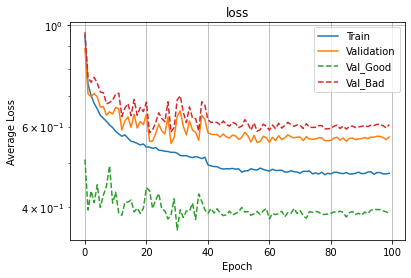

Saved model to ../results/models/foe_cnn_e1d3eefedd01a0383c6c5547367e178d_f0.pt
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Experiments for fold 1 starts...


Training and validating with:
        Autoencoder training set size: 14936
        Orientation estimation training set size: 75395
        Validation set size (good): 4010
        Validation set size (bad): 15353


EPOCH 1/100	LOSS for train/good val/bad val:	0.949 / 0.891 / 0.357 / 1.030


RMSE for good train/bad train good val/bad val:		9.7° / 20.1° / 5.3° / 19.0°


ACC for good train/bad train good val/bad val:		76.6% / 62.5% / 86.1% / 64.4%


EPOCH 2/100	LOSS for train/good val/bad val:	0.726 / 0.839 / 0.474 / 0.934


EPOCH 3/100	LOSS for train/good val/bad val:	0.690 / 0.725 / 0.348 / 0.824


EPOCH 4/100	LOSS for train/good val/bad val:	0.668 / 0.881 / 0.341 / 1.022


EPOCH 5/100	LOSS for train/good val/bad val:	0.649 / 0.677 / 0.338 / 0.766


EPOCH 6/100	LOSS for train/good val/bad val:	0.636 / 0.636 / 0.345 / 0.712


EPOCH 7/100	LOSS for train/good val/bad val:	0.627 / 0.635 / 0.351 / 0.710


EPOCH 8/100	LOSS for train/good val/bad val:	0.615 / 0.750 / 0.350 / 0.854


EPOCH 9/100	LOSS for train/good val/bad val:	0.604 / 0.660 / 0.335 / 0.744


EPOCH 10/100	LOSS for train/good val/bad val:	0.599 / 0.702 / 0.352 / 0.794


EPOCH 11/100	LOSS for train/good val/bad val:	0.589 / 0.649 / 0.348 / 0.728


RMSE for good train/bad train good val/bad val:		7.3° / 13.2° / 8.5° / 16.9°


ACC for good train/bad train good val/bad val:		83.1% / 75.2% / 85.5% / 71.9%


EPOCH 12/100	LOSS for train/good val/bad val:	0.587 / 0.597 / 0.352 / 0.661


EPOCH 13/100	LOSS for train/good val/bad val:	0.580 / 0.638 / 0.356 / 0.711


EPOCH 14/100	LOSS for train/good val/bad val:	0.572 / 0.644 / 0.339 / 0.723


EPOCH 15/100	LOSS for train/good val/bad val:	0.569 / 0.636 / 0.352 / 0.711


EPOCH 16/100	LOSS for train/good val/bad val:	0.566 / 0.565 / 0.315 / 0.630


EPOCH 17/100	LOSS for train/good val/bad val:	0.561 / 0.590 / 0.318 / 0.660


EPOCH 18/100	LOSS for train/good val/bad val:	0.558 / 0.582 / 0.333 / 0.647


EPOCH 19/100	LOSS for train/good val/bad val:	0.556 / 0.573 / 0.318 / 0.639


EPOCH 20/100	LOSS for train/good val/bad val:	0.555 / 0.590 / 0.313 / 0.662


EPOCH 21/100	LOSS for train/good val/bad val:	0.548 / 0.527 / 0.313 / 0.583


RMSE for good train/bad train good val/bad val:		6.9° / 11.4° / 6.5° / 10.5°


ACC for good train/bad train good val/bad val:		83.8% / 76.4% / 86.8% / 76.1%


EPOCH 22/100	LOSS for train/good val/bad val:	0.550 / 0.600 / 0.340 / 0.668


EPOCH 23/100	LOSS for train/good val/bad val:	0.549 / 0.619 / 0.329 / 0.695


EPOCH 24/100	LOSS for train/good val/bad val:	0.543 / 0.630 / 0.341 / 0.705


EPOCH 25/100	LOSS for train/good val/bad val:	0.543 / 0.580 / 0.354 / 0.640


EPOCH 26/100	LOSS for train/good val/bad val:	0.537 / 0.581 / 0.339 / 0.644


EPOCH 27/100	LOSS for train/good val/bad val:	0.542 / 0.569 / 0.321 / 0.634


EPOCH 28/100	LOSS for train/good val/bad val:	0.536 / 0.549 / 0.328 / 0.606


EPOCH 29/100	LOSS for train/good val/bad val:	0.535 / 0.545 / 0.326 / 0.603


EPOCH 30/100	LOSS for train/good val/bad val:	0.535 / 0.587 / 0.335 / 0.653


EPOCH 31/100	LOSS for train/good val/bad val:	0.532 / 0.554 / 0.337 / 0.610


RMSE for good train/bad train good val/bad val:		6.8° / 10.9° / 6.7° / 11.0°


ACC for good train/bad train good val/bad val:		83.9% / 77.1% / 85.9% / 75.5%


EPOCH 32/100	LOSS for train/good val/bad val:	0.532 / 0.576 / 0.332 / 0.640


EPOCH 33/100	LOSS for train/good val/bad val:	0.527 / 0.550 / 0.313 / 0.612


EPOCH 34/100	LOSS for train/good val/bad val:	0.528 / 0.566 / 0.327 / 0.629


EPOCH 35/100	LOSS for train/good val/bad val:	0.524 / 0.568 / 0.307 / 0.636


EPOCH 36/100	LOSS for train/good val/bad val:	0.520 / 0.570 / 0.336 / 0.631


EPOCH 37/100	LOSS for train/good val/bad val:	0.524 / 0.593 / 0.332 / 0.661


EPOCH 38/100	LOSS for train/good val/bad val:	0.523 / 0.553 / 0.328 / 0.611


EPOCH 39/100	LOSS for train/good val/bad val:	0.522 / 0.596 / 0.326 / 0.666


EPOCH 40/100	LOSS for train/good val/bad val:	0.515 / 0.614 / 0.312 / 0.693


EPOCH 41/100	LOSS for train/good val/bad val:	0.508 / 0.563 / 0.323 / 0.625


RMSE for good train/bad train good val/bad val:		6.4° / 10.0° / 6.5° / 12.1°


ACC for good train/bad train good val/bad val:		84.6% / 78.0% / 86.7% / 75.2%


EPOCH 42/100	LOSS for train/good val/bad val:	0.501 / 0.547 / 0.323 / 0.606


EPOCH 43/100	LOSS for train/good val/bad val:	0.499 / 0.522 / 0.309 / 0.577


EPOCH 44/100	LOSS for train/good val/bad val:	0.497 / 0.530 / 0.307 / 0.588


EPOCH 45/100	LOSS for train/good val/bad val:	0.495 / 0.537 / 0.314 / 0.596


EPOCH 46/100	LOSS for train/good val/bad val:	0.493 / 0.539 / 0.313 / 0.598


EPOCH 47/100	LOSS for train/good val/bad val:	0.491 / 0.526 / 0.307 / 0.584


EPOCH 48/100	LOSS for train/good val/bad val:	0.497 / 0.528 / 0.309 / 0.585


EPOCH 49/100	LOSS for train/good val/bad val:	0.492 / 0.543 / 0.314 / 0.603


EPOCH 50/100	LOSS for train/good val/bad val:	0.490 / 0.540 / 0.309 / 0.600


EPOCH 51/100	LOSS for train/good val/bad val:	0.490 / 0.534 / 0.315 / 0.591


RMSE for good train/bad train good val/bad val:		6.4° / 9.6° / 5.8° / 10.4°


ACC for good train/bad train good val/bad val:		85.0% / 78.9% / 87.1% / 75.7%


EPOCH 52/100	LOSS for train/good val/bad val:	0.492 / 0.539 / 0.314 / 0.598


EPOCH 53/100	LOSS for train/good val/bad val:	0.488 / 0.538 / 0.312 / 0.598


EPOCH 54/100	LOSS for train/good val/bad val:	0.488 / 0.534 / 0.308 / 0.594


EPOCH 55/100	LOSS for train/good val/bad val:	0.490 / 0.549 / 0.321 / 0.608


EPOCH 56/100	LOSS for train/good val/bad val:	0.491 / 0.525 / 0.314 / 0.580


EPOCH 57/100	LOSS for train/good val/bad val:	0.491 / 0.537 / 0.311 / 0.596


EPOCH 58/100	LOSS for train/good val/bad val:	0.484 / 0.521 / 0.296 / 0.580


EPOCH 59/100	LOSS for train/good val/bad val:	0.488 / 0.536 / 0.316 / 0.594


EPOCH 60/100	LOSS for train/good val/bad val:	0.490 / 0.528 / 0.320 / 0.582


EPOCH 61/100	LOSS for train/good val/bad val:	0.488 / 0.529 / 0.313 / 0.585


RMSE for good train/bad train good val/bad val:		6.3° / 9.6° / 5.4° / 9.6°


ACC for good train/bad train good val/bad val:		84.8% / 79.0% / 86.9% / 76.0%


EPOCH 62/100	LOSS for train/good val/bad val:	0.485 / 0.545 / 0.322 / 0.603


EPOCH 63/100	LOSS for train/good val/bad val:	0.485 / 0.530 / 0.311 / 0.587


EPOCH 64/100	LOSS for train/good val/bad val:	0.489 / 0.537 / 0.315 / 0.595


EPOCH 65/100	LOSS for train/good val/bad val:	0.484 / 0.549 / 0.317 / 0.610


EPOCH 66/100	LOSS for train/good val/bad val:	0.486 / 0.543 / 0.319 / 0.602


EPOCH 67/100	LOSS for train/good val/bad val:	0.483 / 0.545 / 0.332 / 0.601


EPOCH 68/100	LOSS for train/good val/bad val:	0.483 / 0.535 / 0.320 / 0.591


EPOCH 69/100	LOSS for train/good val/bad val:	0.484 / 0.533 / 0.319 / 0.589


EPOCH 70/100	LOSS for train/good val/bad val:	0.484 / 0.550 / 0.329 / 0.608


EPOCH 71/100	LOSS for train/good val/bad val:	0.480 / 0.532 / 0.311 / 0.590


RMSE for good train/bad train good val/bad val:		6.3° / 9.4° / 6.4° / 10.0°


ACC for good train/bad train good val/bad val:		85.4% / 79.1% / 86.9% / 76.2%


EPOCH 72/100	LOSS for train/good val/bad val:	0.484 / 0.537 / 0.326 / 0.592


EPOCH 73/100	LOSS for train/good val/bad val:	0.485 / 0.537 / 0.317 / 0.594


EPOCH 74/100	LOSS for train/good val/bad val:	0.484 / 0.531 / 0.316 / 0.587


EPOCH 75/100	LOSS for train/good val/bad val:	0.483 / 0.566 / 0.331 / 0.627


EPOCH 76/100	LOSS for train/good val/bad val:	0.478 / 0.534 / 0.323 / 0.589


EPOCH 77/100	LOSS for train/good val/bad val:	0.479 / 0.531 / 0.316 / 0.587


EPOCH 78/100	LOSS for train/good val/bad val:	0.484 / 0.529 / 0.311 / 0.586


EPOCH 79/100	LOSS for train/good val/bad val:	0.482 / 0.535 / 0.318 / 0.592


EPOCH 80/100	LOSS for train/good val/bad val:	0.481 / 0.524 / 0.315 / 0.579


EPOCH 81/100	LOSS for train/good val/bad val:	0.480 / 0.535 / 0.320 / 0.592


RMSE for good train/bad train good val/bad val:		6.4° / 9.4° / 6.4° / 10.0°


ACC for good train/bad train good val/bad val:		85.6% / 79.2% / 86.5% / 76.1%


EPOCH 82/100	LOSS for train/good val/bad val:	0.477 / 0.549 / 0.332 / 0.606


EPOCH 83/100	LOSS for train/good val/bad val:	0.483 / 0.524 / 0.321 / 0.577


EPOCH 84/100	LOSS for train/good val/bad val:	0.482 / 0.542 / 0.318 / 0.600


EPOCH 85/100	LOSS for train/good val/bad val:	0.483 / 0.522 / 0.313 / 0.577


EPOCH 86/100	LOSS for train/good val/bad val:	0.481 / 0.527 / 0.319 / 0.581


EPOCH 87/100	LOSS for train/good val/bad val:	0.479 / 0.520 / 0.309 / 0.575


EPOCH 88/100	LOSS for train/good val/bad val:	0.483 / 0.555 / 0.321 / 0.617


EPOCH 89/100	LOSS for train/good val/bad val:	0.484 / 0.532 / 0.319 / 0.588


EPOCH 90/100	LOSS for train/good val/bad val:	0.477 / 0.520 / 0.310 / 0.575


EPOCH 91/100	LOSS for train/good val/bad val:	0.481 / 0.533 / 0.322 / 0.588


RMSE for good train/bad train good val/bad val:		6.5° / 9.3° / 6.6° / 10.0°


ACC for good train/bad train good val/bad val:		85.4% / 79.2% / 86.8% / 76.4%


EPOCH 92/100	LOSS for train/good val/bad val:	0.480 / 0.532 / 0.316 / 0.588


EPOCH 93/100	LOSS for train/good val/bad val:	0.477 / 0.541 / 0.324 / 0.598


EPOCH 94/100	LOSS for train/good val/bad val:	0.482 / 0.543 / 0.324 / 0.600


EPOCH 95/100	LOSS for train/good val/bad val:	0.479 / 0.536 / 0.313 / 0.594


EPOCH 96/100	LOSS for train/good val/bad val:	0.481 / 0.523 / 0.318 / 0.576


EPOCH 97/100	LOSS for train/good val/bad val:	0.478 / 0.536 / 0.317 / 0.593


EPOCH 98/100	LOSS for train/good val/bad val:	0.477 / 0.540 / 0.322 / 0.597


EPOCH 99/100	LOSS for train/good val/bad val:	0.479 / 0.537 / 0.324 / 0.592


EPOCH 100/100	LOSS for train/good val/bad val:	0.481 / 0.538 / 0.312 / 0.597


RMSE for good train/bad train good val/bad val:		6.3° / 9.3° / 6.9° / 11.0°


ACC for good train/bad train good val/bad val:		85.3% / 79.1% / 87.3% / 76.4%


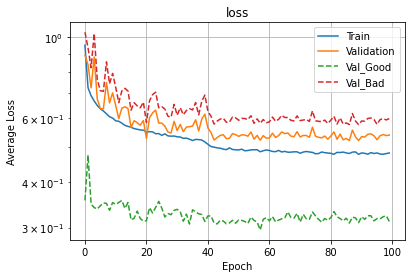

Saved model to ../results/models/foe_cnn_e1d3eefedd01a0383c6c5547367e178d_f1.pt
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Experiments for fold 2 starts...


Training and validating with:
        Autoencoder training set size: 15455
        Orientation estimation training set size: 76241
        Validation set size (good): 3491
        Validation set size (bad): 15026


EPOCH 1/100	LOSS for train/good val/bad val:	0.976 / 0.905 / 0.857 / 0.916


RMSE for good train/bad train good val/bad val:		9.8° / 21.4° / 16.2° / 18.2°


ACC for good train/bad train good val/bad val:		76.9% / 60.6% / 66.8% / 66.0%


EPOCH 2/100	LOSS for train/good val/bad val:	0.755 / 0.821 / 0.619 / 0.867


EPOCH 3/100	LOSS for train/good val/bad val:	0.716 / 0.650 / 0.567 / 0.669


EPOCH 4/100	LOSS for train/good val/bad val:	0.680 / 0.641 / 0.574 / 0.657


EPOCH 5/100	LOSS for train/good val/bad val:	0.659 / 0.687 / 0.574 / 0.713


EPOCH 6/100	LOSS for train/good val/bad val:	0.640 / 0.633 / 0.525 / 0.658


EPOCH 7/100	LOSS for train/good val/bad val:	0.626 / 0.714 / 0.568 / 0.748


EPOCH 8/100	LOSS for train/good val/bad val:	0.612 / 0.640 / 0.512 / 0.669


EPOCH 9/100	LOSS for train/good val/bad val:	0.605 / 0.720 / 0.571 / 0.754


EPOCH 10/100	LOSS for train/good val/bad val:	0.600 / 0.617 / 0.558 / 0.630


EPOCH 11/100	LOSS for train/good val/bad val:	0.590 / 0.813 / 0.582 / 0.867


RMSE for good train/bad train good val/bad val:		7.1° / 13.2° / 9.9° / 16.7°


ACC for good train/bad train good val/bad val:		84.6% / 74.5% / 76.2% / 71.2%


EPOCH 12/100	LOSS for train/good val/bad val:	0.581 / 0.654 / 0.525 / 0.684


EPOCH 13/100	LOSS for train/good val/bad val:	0.580 / 0.654 / 0.561 / 0.676


EPOCH 14/100	LOSS for train/good val/bad val:	0.569 / 0.666 / 0.532 / 0.698


EPOCH 15/100	LOSS for train/good val/bad val:	0.565 / 0.649 / 0.534 / 0.676


EPOCH 16/100	LOSS for train/good val/bad val:	0.561 / 0.610 / 0.520 / 0.630


EPOCH 17/100	LOSS for train/good val/bad val:	0.561 / 0.617 / 0.507 / 0.643


EPOCH 18/100	LOSS for train/good val/bad val:	0.552 / 0.691 / 0.532 / 0.728


EPOCH 19/100	LOSS for train/good val/bad val:	0.549 / 0.646 / 0.553 / 0.668


EPOCH 20/100	LOSS for train/good val/bad val:	0.552 / 0.606 / 0.492 / 0.632


EPOCH 21/100	LOSS for train/good val/bad val:	0.541 / 0.600 / 0.544 / 0.613


RMSE for good train/bad train good val/bad val:		6.4° / 11.5° / 8.7° / 10.3°


ACC for good train/bad train good val/bad val:		85.2% / 76.3% / 77.5% / 75.7%


EPOCH 22/100	LOSS for train/good val/bad val:	0.541 / 0.660 / 0.563 / 0.683


EPOCH 23/100	LOSS for train/good val/bad val:	0.537 / 0.657 / 0.549 / 0.682


EPOCH 24/100	LOSS for train/good val/bad val:	0.535 / 0.609 / 0.538 / 0.626


EPOCH 25/100	LOSS for train/good val/bad val:	0.532 / 0.639 / 0.514 / 0.668


EPOCH 26/100	LOSS for train/good val/bad val:	0.530 / 0.589 / 0.541 / 0.600


EPOCH 27/100	LOSS for train/good val/bad val:	0.529 / 0.612 / 0.559 / 0.624


EPOCH 28/100	LOSS for train/good val/bad val:	0.530 / 0.569 / 0.484 / 0.588


EPOCH 29/100	LOSS for train/good val/bad val:	0.525 / 0.560 / 0.508 / 0.572


EPOCH 30/100	LOSS for train/good val/bad val:	0.525 / 0.572 / 0.495 / 0.590


EPOCH 31/100	LOSS for train/good val/bad val:	0.520 / 0.588 / 0.484 / 0.613


RMSE for good train/bad train good val/bad val:		6.4° / 10.8° / 7.4° / 10.9°


ACC for good train/bad train good val/bad val:		85.8% / 77.0% / 80.1% / 76.5%


EPOCH 32/100	LOSS for train/good val/bad val:	0.515 / 0.579 / 0.490 / 0.599


EPOCH 33/100	LOSS for train/good val/bad val:	0.521 / 0.609 / 0.473 / 0.641


EPOCH 34/100	LOSS for train/good val/bad val:	0.517 / 0.578 / 0.488 / 0.599


EPOCH 35/100	LOSS for train/good val/bad val:	0.516 / 0.617 / 0.496 / 0.645


EPOCH 36/100	LOSS for train/good val/bad val:	0.515 / 0.569 / 0.482 / 0.590


EPOCH 37/100	LOSS for train/good val/bad val:	0.512 / 0.563 / 0.492 / 0.579


EPOCH 38/100	LOSS for train/good val/bad val:	0.509 / 0.579 / 0.478 / 0.603


EPOCH 39/100	LOSS for train/good val/bad val:	0.509 / 0.584 / 0.488 / 0.606


EPOCH 40/100	LOSS for train/good val/bad val:	0.512 / 0.594 / 0.536 / 0.608


EPOCH 41/100	LOSS for train/good val/bad val:	0.495 / 0.577 / 0.467 / 0.602


RMSE for good train/bad train good val/bad val:		6.0° / 9.8° / 7.0° / 10.2°


ACC for good train/bad train good val/bad val:		86.1% / 78.1% / 80.4% / 76.8%


EPOCH 42/100	LOSS for train/good val/bad val:	0.490 / 0.583 / 0.458 / 0.612


EPOCH 43/100	LOSS for train/good val/bad val:	0.485 / 0.563 / 0.461 / 0.587


EPOCH 44/100	LOSS for train/good val/bad val:	0.484 / 0.572 / 0.454 / 0.599


EPOCH 45/100	LOSS for train/good val/bad val:	0.486 / 0.570 / 0.456 / 0.596


EPOCH 46/100	LOSS for train/good val/bad val:	0.485 / 0.585 / 0.459 / 0.614


EPOCH 47/100	LOSS for train/good val/bad val:	0.481 / 0.559 / 0.460 / 0.582


EPOCH 48/100	LOSS for train/good val/bad val:	0.480 / 0.575 / 0.446 / 0.604


EPOCH 49/100	LOSS for train/good val/bad val:	0.480 / 0.562 / 0.455 / 0.586


EPOCH 50/100	LOSS for train/good val/bad val:	0.483 / 0.564 / 0.459 / 0.588


EPOCH 51/100	LOSS for train/good val/bad val:	0.483 / 0.558 / 0.458 / 0.581


RMSE for good train/bad train good val/bad val:		5.9° / 9.5° / 6.9° / 9.6°


ACC for good train/bad train good val/bad val:		86.4% / 78.6% / 80.6% / 77.5%


EPOCH 52/100	LOSS for train/good val/bad val:	0.480 / 0.568 / 0.457 / 0.593


EPOCH 53/100	LOSS for train/good val/bad val:	0.480 / 0.558 / 0.455 / 0.582


EPOCH 54/100	LOSS for train/good val/bad val:	0.481 / 0.580 / 0.455 / 0.609


EPOCH 55/100	LOSS for train/good val/bad val:	0.481 / 0.570 / 0.454 / 0.597


EPOCH 56/100	LOSS for train/good val/bad val:	0.480 / 0.557 / 0.452 / 0.581


EPOCH 57/100	LOSS for train/good val/bad val:	0.476 / 0.568 / 0.452 / 0.595


EPOCH 58/100	LOSS for train/good val/bad val:	0.474 / 0.565 / 0.459 / 0.590


EPOCH 59/100	LOSS for train/good val/bad val:	0.478 / 0.582 / 0.478 / 0.606


EPOCH 60/100	LOSS for train/good val/bad val:	0.474 / 0.561 / 0.462 / 0.584


EPOCH 61/100	LOSS for train/good val/bad val:	0.476 / 0.566 / 0.460 / 0.591


RMSE for good train/bad train good val/bad val:		5.8° / 9.4° / 6.9° / 9.8°


ACC for good train/bad train good val/bad val:		86.3% / 79.1% / 80.5% / 77.7%


EPOCH 62/100	LOSS for train/good val/bad val:	0.476 / 0.582 / 0.455 / 0.612


EPOCH 63/100	LOSS for train/good val/bad val:	0.477 / 0.573 / 0.454 / 0.601


EPOCH 64/100	LOSS for train/good val/bad val:	0.473 / 0.572 / 0.452 / 0.600


EPOCH 65/100	LOSS for train/good val/bad val:	0.476 / 0.565 / 0.446 / 0.592


EPOCH 66/100	LOSS for train/good val/bad val:	0.479 / 0.570 / 0.460 / 0.595


EPOCH 67/100	LOSS for train/good val/bad val:	0.476 / 0.575 / 0.455 / 0.602


EPOCH 68/100	LOSS for train/good val/bad val:	0.473 / 0.557 / 0.444 / 0.584


EPOCH 69/100	LOSS for train/good val/bad val:	0.474 / 0.553 / 0.443 / 0.579


EPOCH 70/100	LOSS for train/good val/bad val:	0.478 / 0.567 / 0.453 / 0.593


EPOCH 71/100	LOSS for train/good val/bad val:	0.474 / 0.573 / 0.469 / 0.597


RMSE for good train/bad train good val/bad val:		5.9° / 9.3° / 7.0° / 9.8°


ACC for good train/bad train good val/bad val:		86.5% / 78.8% / 79.8% / 77.1%


EPOCH 72/100	LOSS for train/good val/bad val:	0.476 / 0.573 / 0.466 / 0.598


EPOCH 73/100	LOSS for train/good val/bad val:	0.475 / 0.557 / 0.457 / 0.581


EPOCH 74/100	LOSS for train/good val/bad val:	0.475 / 0.555 / 0.453 / 0.579


EPOCH 75/100	LOSS for train/good val/bad val:	0.476 / 0.573 / 0.463 / 0.598


EPOCH 76/100	LOSS for train/good val/bad val:	0.469 / 0.575 / 0.451 / 0.603


EPOCH 77/100	LOSS for train/good val/bad val:	0.470 / 0.563 / 0.448 / 0.589


EPOCH 78/100	LOSS for train/good val/bad val:	0.473 / 0.574 / 0.456 / 0.601


EPOCH 79/100	LOSS for train/good val/bad val:	0.467 / 0.557 / 0.455 / 0.580


EPOCH 80/100	LOSS for train/good val/bad val:	0.474 / 0.570 / 0.453 / 0.597


EPOCH 81/100	LOSS for train/good val/bad val:	0.466 / 0.555 / 0.446 / 0.580


RMSE for good train/bad train good val/bad val:		6.0° / 9.2° / 6.6° / 9.6°


ACC for good train/bad train good val/bad val:		86.7% / 79.4% / 81.1% / 77.4%


EPOCH 82/100	LOSS for train/good val/bad val:	0.472 / 0.560 / 0.460 / 0.584


EPOCH 83/100	LOSS for train/good val/bad val:	0.469 / 0.574 / 0.461 / 0.601


EPOCH 84/100	LOSS for train/good val/bad val:	0.468 / 0.573 / 0.456 / 0.600


EPOCH 85/100	LOSS for train/good val/bad val:	0.470 / 0.581 / 0.455 / 0.611


EPOCH 86/100	LOSS for train/good val/bad val:	0.469 / 0.566 / 0.450 / 0.593


EPOCH 87/100	LOSS for train/good val/bad val:	0.471 / 0.573 / 0.451 / 0.601


EPOCH 88/100	LOSS for train/good val/bad val:	0.472 / 0.565 / 0.449 / 0.592


EPOCH 89/100	LOSS for train/good val/bad val:	0.470 / 0.575 / 0.453 / 0.604


EPOCH 90/100	LOSS for train/good val/bad val:	0.470 / 0.567 / 0.449 / 0.595


EPOCH 91/100	LOSS for train/good val/bad val:	0.472 / 0.559 / 0.448 / 0.585


RMSE for good train/bad train good val/bad val:		6.0° / 9.2° / 6.7° / 9.7°


ACC for good train/bad train good val/bad val:		86.4% / 79.3% / 80.7% / 77.4%


EPOCH 92/100	LOSS for train/good val/bad val:	0.472 / 0.563 / 0.449 / 0.590


EPOCH 93/100	LOSS for train/good val/bad val:	0.472 / 0.572 / 0.451 / 0.600


EPOCH 94/100	LOSS for train/good val/bad val:	0.468 / 0.564 / 0.450 / 0.590


EPOCH 95/100	LOSS for train/good val/bad val:	0.471 / 0.560 / 0.446 / 0.587


EPOCH 96/100	LOSS for train/good val/bad val:	0.468 / 0.563 / 0.448 / 0.589


EPOCH 97/100	LOSS for train/good val/bad val:	0.468 / 0.563 / 0.449 / 0.590


EPOCH 98/100	LOSS for train/good val/bad val:	0.472 / 0.561 / 0.451 / 0.587


EPOCH 99/100	LOSS for train/good val/bad val:	0.469 / 0.557 / 0.453 / 0.582


EPOCH 100/100	LOSS for train/good val/bad val:	0.468 / 0.565 / 0.452 / 0.591


RMSE for good train/bad train good val/bad val:		5.9° / 9.2° / 6.8° / 9.8°


ACC for good train/bad train good val/bad val:		86.9% / 79.3% / 80.6% / 77.5%


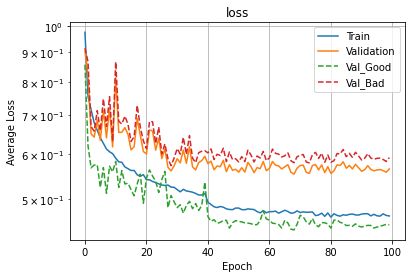

Saved model to ../results/models/foe_cnn_e1d3eefedd01a0383c6c5547367e178d_f2.pt
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Experiments for fold 3 starts...


Training and validating with:
        Autoencoder training set size: 14722
        Orientation estimation training set size: 75795
        Validation set size (good): 4224
        Validation set size (bad): 14739


EPOCH 1/100	LOSS for train/good val/bad val:	0.935 / 0.794 / 0.420 / 0.901


RMSE for good train/bad train good val/bad val:		9.5° / 19.9° / 5.9° / 18.1°


ACC for good train/bad train good val/bad val:		77.5% / 63.0% / 82.1% / 65.7%


EPOCH 2/100	LOSS for train/good val/bad val:	0.730 / 0.756 / 0.365 / 0.868


EPOCH 3/100	LOSS for train/good val/bad val:	0.689 / 0.746 / 0.402 / 0.845


EPOCH 4/100	LOSS for train/good val/bad val:	0.671 / 0.690 / 0.358 / 0.785


EPOCH 5/100	LOSS for train/good val/bad val:	0.656 / 0.822 / 0.441 / 0.932


EPOCH 6/100	LOSS for train/good val/bad val:	0.635 / 0.664 / 0.364 / 0.749


EPOCH 7/100	LOSS for train/good val/bad val:	0.625 / 0.630 / 0.364 / 0.707


EPOCH 8/100	LOSS for train/good val/bad val:	0.617 / 0.586 / 0.339 / 0.657


EPOCH 9/100	LOSS for train/good val/bad val:	0.611 / 0.578 / 0.361 / 0.640


EPOCH 10/100	LOSS for train/good val/bad val:	0.599 / 0.594 / 0.350 / 0.664


EPOCH 11/100	LOSS for train/good val/bad val:	0.593 / 0.590 / 0.357 / 0.656


RMSE for good train/bad train good val/bad val:		7.3° / 13.3° / 5.9° / 12.7°


ACC for good train/bad train good val/bad val:		83.6% / 74.6% / 85.0% / 74.4%


EPOCH 12/100	LOSS for train/good val/bad val:	0.589 / 0.605 / 0.374 / 0.671


EPOCH 13/100	LOSS for train/good val/bad val:	0.580 / 0.603 / 0.369 / 0.670


EPOCH 14/100	LOSS for train/good val/bad val:	0.577 / 0.603 / 0.364 / 0.672


EPOCH 15/100	LOSS for train/good val/bad val:	0.569 / 0.713 / 0.364 / 0.813


EPOCH 16/100	LOSS for train/good val/bad val:	0.565 / 0.577 / 0.346 / 0.643


EPOCH 17/100	LOSS for train/good val/bad val:	0.560 / 0.649 / 0.333 / 0.740


EPOCH 18/100	LOSS for train/good val/bad val:	0.558 / 0.669 / 0.411 / 0.743


EPOCH 19/100	LOSS for train/good val/bad val:	0.552 / 0.581 / 0.363 / 0.643


EPOCH 20/100	LOSS for train/good val/bad val:	0.549 / 0.538 / 0.340 / 0.594


EPOCH 21/100	LOSS for train/good val/bad val:	0.545 / 0.565 / 0.352 / 0.626


RMSE for good train/bad train good val/bad val:		6.7° / 11.4° / 5.5° / 12.8°


ACC for good train/bad train good val/bad val:		83.8% / 76.7% / 84.6% / 75.0%


EPOCH 22/100	LOSS for train/good val/bad val:	0.540 / 0.555 / 0.355 / 0.612


EPOCH 23/100	LOSS for train/good val/bad val:	0.541 / 0.546 / 0.366 / 0.597


EPOCH 24/100	LOSS for train/good val/bad val:	0.540 / 0.555 / 0.353 / 0.613


EPOCH 25/100	LOSS for train/good val/bad val:	0.531 / 0.604 / 0.374 / 0.670


EPOCH 26/100	LOSS for train/good val/bad val:	0.531 / 0.560 / 0.372 / 0.614


EPOCH 27/100	LOSS for train/good val/bad val:	0.527 / 0.562 / 0.354 / 0.622


EPOCH 28/100	LOSS for train/good val/bad val:	0.526 / 0.587 / 0.363 / 0.652


EPOCH 29/100	LOSS for train/good val/bad val:	0.527 / 0.550 / 0.346 / 0.609


EPOCH 30/100	LOSS for train/good val/bad val:	0.524 / 0.592 / 0.360 / 0.659


EPOCH 31/100	LOSS for train/good val/bad val:	0.526 / 0.520 / 0.335 / 0.573


RMSE for good train/bad train good val/bad val:		6.5° / 10.7° / 5.5° / 10.4°


ACC for good train/bad train good val/bad val:		83.8% / 77.4% / 85.5% / 76.4%


EPOCH 32/100	LOSS for train/good val/bad val:	0.523 / 0.570 / 0.370 / 0.628


EPOCH 33/100	LOSS for train/good val/bad val:	0.517 / 0.545 / 0.341 / 0.603


EPOCH 34/100	LOSS for train/good val/bad val:	0.518 / 0.576 / 0.329 / 0.646


EPOCH 35/100	LOSS for train/good val/bad val:	0.516 / 0.601 / 0.339 / 0.676


EPOCH 36/100	LOSS for train/good val/bad val:	0.518 / 0.573 / 0.350 / 0.637


EPOCH 37/100	LOSS for train/good val/bad val:	0.516 / 0.565 / 0.343 / 0.629


EPOCH 38/100	LOSS for train/good val/bad val:	0.516 / 0.639 / 0.356 / 0.720


EPOCH 39/100	LOSS for train/good val/bad val:	0.508 / 0.617 / 0.365 / 0.689


EPOCH 40/100	LOSS for train/good val/bad val:	0.509 / 0.614 / 0.346 / 0.691


EPOCH 41/100	LOSS for train/good val/bad val:	0.497 / 0.542 / 0.335 / 0.601


RMSE for good train/bad train good val/bad val:		6.0° / 9.7° / 5.0° / 11.6°


ACC for good train/bad train good val/bad val:		85.2% / 78.5% / 85.9% / 75.5%


EPOCH 42/100	LOSS for train/good val/bad val:	0.490 / 0.548 / 0.339 / 0.608


EPOCH 43/100	LOSS for train/good val/bad val:	0.487 / 0.543 / 0.334 / 0.603


EPOCH 44/100	LOSS for train/good val/bad val:	0.483 / 0.544 / 0.334 / 0.604


EPOCH 45/100	LOSS for train/good val/bad val:	0.489 / 0.558 / 0.339 / 0.621


EPOCH 46/100	LOSS for train/good val/bad val:	0.487 / 0.539 / 0.338 / 0.596


EPOCH 47/100	LOSS for train/good val/bad val:	0.487 / 0.536 / 0.343 / 0.591


EPOCH 48/100	LOSS for train/good val/bad val:	0.488 / 0.534 / 0.348 / 0.588


EPOCH 49/100	LOSS for train/good val/bad val:	0.485 / 0.537 / 0.341 / 0.594


EPOCH 50/100	LOSS for train/good val/bad val:	0.485 / 0.530 / 0.347 / 0.583


EPOCH 51/100	LOSS for train/good val/bad val:	0.481 / 0.526 / 0.342 / 0.579


RMSE for good train/bad train good val/bad val:		6.2° / 9.4° / 5.2° / 11.0°


ACC for good train/bad train good val/bad val:		85.2% / 79.2% / 85.8% / 76.6%


EPOCH 52/100	LOSS for train/good val/bad val:	0.477 / 0.527 / 0.340 / 0.581


EPOCH 53/100	LOSS for train/good val/bad val:	0.482 / 0.541 / 0.338 / 0.599


EPOCH 54/100	LOSS for train/good val/bad val:	0.481 / 0.549 / 0.341 / 0.608


EPOCH 55/100	LOSS for train/good val/bad val:	0.481 / 0.537 / 0.334 / 0.595


EPOCH 56/100	LOSS for train/good val/bad val:	0.479 / 0.534 / 0.337 / 0.591


EPOCH 57/100	LOSS for train/good val/bad val:	0.480 / 0.535 / 0.337 / 0.592


EPOCH 58/100	LOSS for train/good val/bad val:	0.478 / 0.538 / 0.338 / 0.596


EPOCH 59/100	LOSS for train/good val/bad val:	0.481 / 0.536 / 0.348 / 0.590


EPOCH 60/100	LOSS for train/good val/bad val:	0.480 / 0.535 / 0.342 / 0.590


EPOCH 61/100	LOSS for train/good val/bad val:	0.481 / 0.538 / 0.344 / 0.594


RMSE for good train/bad train good val/bad val:		6.0° / 9.3° / 5.1° / 11.5°


ACC for good train/bad train good val/bad val:		85.5% / 79.2% / 85.7% / 76.7%


EPOCH 62/100	LOSS for train/good val/bad val:	0.486 / 0.533 / 0.342 / 0.588


EPOCH 63/100	LOSS for train/good val/bad val:	0.483 / 0.525 / 0.332 / 0.581


EPOCH 64/100	LOSS for train/good val/bad val:	0.477 / 0.542 / 0.334 / 0.601


EPOCH 65/100	LOSS for train/good val/bad val:	0.478 / 0.521 / 0.337 / 0.574


EPOCH 66/100	LOSS for train/good val/bad val:	0.480 / 0.539 / 0.334 / 0.597


EPOCH 67/100	LOSS for train/good val/bad val:	0.478 / 0.544 / 0.334 / 0.604


EPOCH 68/100	LOSS for train/good val/bad val:	0.478 / 0.540 / 0.332 / 0.600


EPOCH 69/100	LOSS for train/good val/bad val:	0.478 / 0.542 / 0.344 / 0.598


EPOCH 70/100	LOSS for train/good val/bad val:	0.481 / 0.519 / 0.338 / 0.571


EPOCH 71/100	LOSS for train/good val/bad val:	0.481 / 0.522 / 0.334 / 0.576


RMSE for good train/bad train good val/bad val:		6.2° / 9.2° / 4.9° / 10.7°


ACC for good train/bad train good val/bad val:		85.4% / 78.9% / 86.0% / 76.7%


EPOCH 72/100	LOSS for train/good val/bad val:	0.471 / 0.539 / 0.339 / 0.596


EPOCH 73/100	LOSS for train/good val/bad val:	0.476 / 0.538 / 0.334 / 0.596


EPOCH 74/100	LOSS for train/good val/bad val:	0.474 / 0.541 / 0.334 / 0.600


EPOCH 75/100	LOSS for train/good val/bad val:	0.478 / 0.538 / 0.338 / 0.595


EPOCH 76/100	LOSS for train/good val/bad val:	0.476 / 0.534 / 0.335 / 0.591


EPOCH 77/100	LOSS for train/good val/bad val:	0.476 / 0.526 / 0.333 / 0.581


EPOCH 78/100	LOSS for train/good val/bad val:	0.475 / 0.531 / 0.335 / 0.586


EPOCH 79/100	LOSS for train/good val/bad val:	0.475 / 0.529 / 0.339 / 0.584


EPOCH 80/100	LOSS for train/good val/bad val:	0.470 / 0.539 / 0.335 / 0.597


EPOCH 81/100	LOSS for train/good val/bad val:	0.468 / 0.520 / 0.341 / 0.572


RMSE for good train/bad train good val/bad val:		6.2° / 9.2° / 4.9° / 10.7°


ACC for good train/bad train good val/bad val:		85.9% / 79.6% / 85.4% / 76.8%


EPOCH 82/100	LOSS for train/good val/bad val:	0.475 / 0.527 / 0.336 / 0.582


EPOCH 83/100	LOSS for train/good val/bad val:	0.478 / 0.525 / 0.336 / 0.579


EPOCH 84/100	LOSS for train/good val/bad val:	0.476 / 0.530 / 0.337 / 0.585


EPOCH 85/100	LOSS for train/good val/bad val:	0.474 / 0.523 / 0.339 / 0.575


EPOCH 86/100	LOSS for train/good val/bad val:	0.470 / 0.531 / 0.336 / 0.587


EPOCH 87/100	LOSS for train/good val/bad val:	0.469 / 0.528 / 0.335 / 0.583


EPOCH 88/100	LOSS for train/good val/bad val:	0.473 / 0.530 / 0.339 / 0.585


EPOCH 89/100	LOSS for train/good val/bad val:	0.470 / 0.526 / 0.333 / 0.581


EPOCH 90/100	LOSS for train/good val/bad val:	0.473 / 0.545 / 0.341 / 0.604


EPOCH 91/100	LOSS for train/good val/bad val:	0.473 / 0.523 / 0.333 / 0.578


RMSE for good train/bad train good val/bad val:		6.0° / 9.2° / 4.9° / 10.8°


ACC for good train/bad train good val/bad val:		85.9% / 79.1% / 85.8% / 76.4%


EPOCH 92/100	LOSS for train/good val/bad val:	0.475 / 0.538 / 0.334 / 0.596


EPOCH 93/100	LOSS for train/good val/bad val:	0.472 / 0.524 / 0.334 / 0.578


EPOCH 94/100	LOSS for train/good val/bad val:	0.473 / 0.522 / 0.335 / 0.576


EPOCH 95/100	LOSS for train/good val/bad val:	0.474 / 0.532 / 0.331 / 0.589


EPOCH 96/100	LOSS for train/good val/bad val:	0.472 / 0.523 / 0.335 / 0.577


EPOCH 97/100	LOSS for train/good val/bad val:	0.469 / 0.528 / 0.336 / 0.583


EPOCH 98/100	LOSS for train/good val/bad val:	0.472 / 0.528 / 0.337 / 0.582


EPOCH 99/100	LOSS for train/good val/bad val:	0.469 / 0.530 / 0.334 / 0.586


EPOCH 100/100	LOSS for train/good val/bad val:	0.473 / 0.529 / 0.338 / 0.584


RMSE for good train/bad train good val/bad val:		6.0° / 9.0° / 5.0° / 11.2°


ACC for good train/bad train good val/bad val:		85.7% / 79.3% / 85.8% / 76.4%


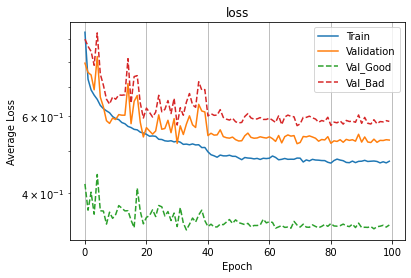

Saved model to ../results/models/foe_cnn_e1d3eefedd01a0383c6c5547367e178d_f3.pt
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Experiments for fold 4 starts...


Training and validating with:
        Autoencoder training set size: 14721
        Orientation estimation training set size: 74873
        Validation set size (good): 4225
        Validation set size (bad): 15660


EPOCH 1/100	LOSS for train/good val/bad val:	0.941 / 0.830 / 0.402 / 0.946


RMSE for good train/bad train good val/bad val:		9.8° / 19.7° / 4.8° / 17.0°


ACC for good train/bad train good val/bad val:		76.6% / 62.5% / 83.6% / 64.6%


EPOCH 2/100	LOSS for train/good val/bad val:	0.734 / 0.669 / 0.399 / 0.742


EPOCH 3/100	LOSS for train/good val/bad val:	0.692 / 0.707 / 0.421 / 0.784


EPOCH 4/100	LOSS for train/good val/bad val:	0.670 / 0.904 / 0.434 / 1.031


EPOCH 5/100	LOSS for train/good val/bad val:	0.655 / 0.662 / 0.383 / 0.737


EPOCH 6/100	LOSS for train/good val/bad val:	0.645 / 0.647 / 0.395 / 0.715


EPOCH 7/100	LOSS for train/good val/bad val:	0.629 / 0.697 / 0.366 / 0.787


EPOCH 8/100	LOSS for train/good val/bad val:	0.623 / 0.691 / 0.390 / 0.772


EPOCH 9/100	LOSS for train/good val/bad val:	0.609 / 0.672 / 0.393 / 0.747


EPOCH 10/100	LOSS for train/good val/bad val:	0.607 / 0.671 / 0.385 / 0.749


EPOCH 11/100	LOSS for train/good val/bad val:	0.597 / 0.636 / 0.396 / 0.701


RMSE for good train/bad train good val/bad val:		7.4° / 13.5° / 6.0° / 13.7°


ACC for good train/bad train good val/bad val:		83.0% / 74.9% / 83.9% / 73.0%


EPOCH 12/100	LOSS for train/good val/bad val:	0.591 / 0.626 / 0.392 / 0.690


EPOCH 13/100	LOSS for train/good val/bad val:	0.584 / 0.597 / 0.375 / 0.657


EPOCH 14/100	LOSS for train/good val/bad val:	0.579 / 0.585 / 0.407 / 0.634


EPOCH 15/100	LOSS for train/good val/bad val:	0.572 / 0.602 / 0.368 / 0.664


EPOCH 16/100	LOSS for train/good val/bad val:	0.570 / 0.587 / 0.365 / 0.647


EPOCH 17/100	LOSS for train/good val/bad val:	0.566 / 0.580 / 0.402 / 0.628


EPOCH 18/100	LOSS for train/good val/bad val:	0.564 / 0.573 / 0.394 / 0.621


EPOCH 19/100	LOSS for train/good val/bad val:	0.561 / 0.568 / 0.368 / 0.621


EPOCH 20/100	LOSS for train/good val/bad val:	0.551 / 0.592 / 0.376 / 0.650


EPOCH 21/100	LOSS for train/good val/bad val:	0.553 / 0.587 / 0.394 / 0.639


RMSE for good train/bad train good val/bad val:		7.1° / 11.9° / 5.0° / 11.0°


ACC for good train/bad train good val/bad val:		83.6% / 76.2% / 84.3% / 73.9%


EPOCH 22/100	LOSS for train/good val/bad val:	0.546 / 0.593 / 0.392 / 0.647


EPOCH 23/100	LOSS for train/good val/bad val:	0.547 / 0.564 / 0.382 / 0.612


EPOCH 24/100	LOSS for train/good val/bad val:	0.544 / 0.591 / 0.378 / 0.648


EPOCH 25/100	LOSS for train/good val/bad val:	0.542 / 0.575 / 0.368 / 0.630


EPOCH 26/100	LOSS for train/good val/bad val:	0.537 / 0.588 / 0.397 / 0.640


EPOCH 27/100	LOSS for train/good val/bad val:	0.532 / 0.566 / 0.382 / 0.616


EPOCH 28/100	LOSS for train/good val/bad val:	0.528 / 0.632 / 0.395 / 0.695


EPOCH 29/100	LOSS for train/good val/bad val:	0.536 / 0.584 / 0.397 / 0.635


EPOCH 30/100	LOSS for train/good val/bad val:	0.531 / 0.607 / 0.382 / 0.668


EPOCH 31/100	LOSS for train/good val/bad val:	0.535 / 0.558 / 0.384 / 0.605


RMSE for good train/bad train good val/bad val:		6.8° / 11.0° / 4.7° / 10.5°


ACC for good train/bad train good val/bad val:		84.0% / 77.0% / 84.3% / 75.2%


EPOCH 32/100	LOSS for train/good val/bad val:	0.524 / 0.580 / 0.402 / 0.629


EPOCH 33/100	LOSS for train/good val/bad val:	0.523 / 0.613 / 0.385 / 0.675


EPOCH 34/100	LOSS for train/good val/bad val:	0.526 / 0.574 / 0.374 / 0.628


EPOCH 35/100	LOSS for train/good val/bad val:	0.523 / 0.577 / 0.370 / 0.633


EPOCH 36/100	LOSS for train/good val/bad val:	0.522 / 0.588 / 0.366 / 0.648


EPOCH 37/100	LOSS for train/good val/bad val:	0.520 / 0.559 / 0.371 / 0.609


EPOCH 38/100	LOSS for train/good val/bad val:	0.519 / 0.568 / 0.376 / 0.619


EPOCH 39/100	LOSS for train/good val/bad val:	0.517 / 0.637 / 0.379 / 0.707


EPOCH 40/100	LOSS for train/good val/bad val:	0.514 / 0.579 / 0.374 / 0.634


EPOCH 41/100	LOSS for train/good val/bad val:	0.498 / 0.544 / 0.372 / 0.590


RMSE for good train/bad train good val/bad val:		6.5° / 10.0° / 4.8° / 10.6°


ACC for good train/bad train good val/bad val:		84.7% / 78.2% / 85.3% / 75.6%


EPOCH 42/100	LOSS for train/good val/bad val:	0.495 / 0.541 / 0.372 / 0.586


EPOCH 43/100	LOSS for train/good val/bad val:	0.492 / 0.548 / 0.365 / 0.598


EPOCH 44/100	LOSS for train/good val/bad val:	0.495 / 0.543 / 0.372 / 0.590


EPOCH 45/100	LOSS for train/good val/bad val:	0.492 / 0.545 / 0.373 / 0.592


EPOCH 46/100	LOSS for train/good val/bad val:	0.490 / 0.543 / 0.373 / 0.589


EPOCH 47/100	LOSS for train/good val/bad val:	0.490 / 0.543 / 0.367 / 0.591


EPOCH 48/100	LOSS for train/good val/bad val:	0.488 / 0.544 / 0.371 / 0.591


EPOCH 49/100	LOSS for train/good val/bad val:	0.489 / 0.545 / 0.368 / 0.593


EPOCH 50/100	LOSS for train/good val/bad val:	0.486 / 0.547 / 0.366 / 0.595


EPOCH 51/100	LOSS for train/good val/bad val:	0.487 / 0.551 / 0.370 / 0.599


RMSE for good train/bad train good val/bad val:		6.2° / 9.7° / 4.6° / 10.9°


ACC for good train/bad train good val/bad val:		85.3% / 78.6% / 85.1% / 75.4%


EPOCH 52/100	LOSS for train/good val/bad val:	0.488 / 0.552 / 0.369 / 0.601


EPOCH 53/100	LOSS for train/good val/bad val:	0.484 / 0.543 / 0.366 / 0.591


EPOCH 54/100	LOSS for train/good val/bad val:	0.486 / 0.545 / 0.375 / 0.591


EPOCH 55/100	LOSS for train/good val/bad val:	0.485 / 0.550 / 0.373 / 0.598


EPOCH 56/100	LOSS for train/good val/bad val:	0.485 / 0.547 / 0.366 / 0.595


EPOCH 57/100	LOSS for train/good val/bad val:	0.483 / 0.542 / 0.369 / 0.588


EPOCH 58/100	LOSS for train/good val/bad val:	0.483 / 0.544 / 0.366 / 0.593


EPOCH 59/100	LOSS for train/good val/bad val:	0.485 / 0.545 / 0.363 / 0.594


EPOCH 60/100	LOSS for train/good val/bad val:	0.482 / 0.540 / 0.369 / 0.586


EPOCH 61/100	LOSS for train/good val/bad val:	0.483 / 0.548 / 0.366 / 0.597


RMSE for good train/bad train good val/bad val:		6.5° / 9.5° / 4.7° / 10.8°


ACC for good train/bad train good val/bad val:		85.5% / 78.5% / 85.7% / 75.5%


EPOCH 62/100	LOSS for train/good val/bad val:	0.481 / 0.543 / 0.368 / 0.590


EPOCH 63/100	LOSS for train/good val/bad val:	0.484 / 0.544 / 0.364 / 0.593


EPOCH 64/100	LOSS for train/good val/bad val:	0.484 / 0.541 / 0.362 / 0.589


EPOCH 65/100	LOSS for train/good val/bad val:	0.482 / 0.546 / 0.360 / 0.597


EPOCH 66/100	LOSS for train/good val/bad val:	0.484 / 0.544 / 0.364 / 0.592


EPOCH 67/100	LOSS for train/good val/bad val:	0.483 / 0.542 / 0.369 / 0.589


EPOCH 68/100	LOSS for train/good val/bad val:	0.484 / 0.547 / 0.373 / 0.595


EPOCH 69/100	LOSS for train/good val/bad val:	0.478 / 0.549 / 0.371 / 0.597


EPOCH 70/100	LOSS for train/good val/bad val:	0.479 / 0.543 / 0.364 / 0.591


EPOCH 71/100	LOSS for train/good val/bad val:	0.481 / 0.553 / 0.373 / 0.601


RMSE for good train/bad train good val/bad val:		6.4° / 9.5° / 4.6° / 10.7°


ACC for good train/bad train good val/bad val:		85.0% / 79.1% / 84.8% / 75.3%


EPOCH 72/100	LOSS for train/good val/bad val:	0.480 / 0.553 / 0.364 / 0.603


EPOCH 73/100	LOSS for train/good val/bad val:	0.476 / 0.551 / 0.368 / 0.601


EPOCH 74/100	LOSS for train/good val/bad val:	0.479 / 0.544 / 0.374 / 0.590


EPOCH 75/100	LOSS for train/good val/bad val:	0.479 / 0.545 / 0.367 / 0.592


EPOCH 76/100	LOSS for train/good val/bad val:	0.481 / 0.548 / 0.368 / 0.597


EPOCH 77/100	LOSS for train/good val/bad val:	0.479 / 0.555 / 0.365 / 0.606


EPOCH 78/100	LOSS for train/good val/bad val:	0.478 / 0.545 / 0.365 / 0.594


EPOCH 79/100	LOSS for train/good val/bad val:	0.475 / 0.542 / 0.369 / 0.588


EPOCH 80/100	LOSS for train/good val/bad val:	0.478 / 0.545 / 0.364 / 0.593


EPOCH 81/100	LOSS for train/good val/bad val:	0.477 / 0.543 / 0.365 / 0.591


RMSE for good train/bad train good val/bad val:		6.3° / 9.2° / 4.7° / 10.6°


ACC for good train/bad train good val/bad val:		85.2% / 79.3% / 85.2% / 75.6%


EPOCH 82/100	LOSS for train/good val/bad val:	0.480 / 0.549 / 0.367 / 0.598


EPOCH 83/100	LOSS for train/good val/bad val:	0.475 / 0.548 / 0.369 / 0.597


EPOCH 84/100	LOSS for train/good val/bad val:	0.474 / 0.547 / 0.366 / 0.595


EPOCH 85/100	LOSS for train/good val/bad val:	0.477 / 0.545 / 0.368 / 0.592


EPOCH 86/100	LOSS for train/good val/bad val:	0.474 / 0.544 / 0.365 / 0.592


EPOCH 87/100	LOSS for train/good val/bad val:	0.476 / 0.543 / 0.367 / 0.590


EPOCH 88/100	LOSS for train/good val/bad val:	0.480 / 0.546 / 0.364 / 0.595


EPOCH 89/100	LOSS for train/good val/bad val:	0.480 / 0.550 / 0.364 / 0.600


EPOCH 90/100	LOSS for train/good val/bad val:	0.474 / 0.547 / 0.367 / 0.596


EPOCH 91/100	LOSS for train/good val/bad val:	0.473 / 0.551 / 0.367 / 0.601


RMSE for good train/bad train good val/bad val:		6.2° / 9.3° / 4.8° / 10.9°


ACC for good train/bad train good val/bad val:		85.6% / 79.2% / 85.2% / 75.4%


EPOCH 92/100	LOSS for train/good val/bad val:	0.474 / 0.544 / 0.366 / 0.592


EPOCH 93/100	LOSS for train/good val/bad val:	0.475 / 0.547 / 0.369 / 0.595


EPOCH 94/100	LOSS for train/good val/bad val:	0.476 / 0.543 / 0.367 / 0.591


EPOCH 95/100	LOSS for train/good val/bad val:	0.473 / 0.545 / 0.367 / 0.593


EPOCH 96/100	LOSS for train/good val/bad val:	0.474 / 0.548 / 0.369 / 0.597


EPOCH 97/100	LOSS for train/good val/bad val:	0.474 / 0.550 / 0.369 / 0.599


EPOCH 98/100	LOSS for train/good val/bad val:	0.473 / 0.545 / 0.367 / 0.593


EPOCH 99/100	LOSS for train/good val/bad val:	0.475 / 0.545 / 0.368 / 0.593


EPOCH 100/100	LOSS for train/good val/bad val:	0.478 / 0.540 / 0.363 / 0.588


RMSE for good train/bad train good val/bad val:		6.4° / 9.3° / 4.5° / 10.4°


ACC for good train/bad train good val/bad val:		85.2% / 79.2% / 85.0% / 75.8%


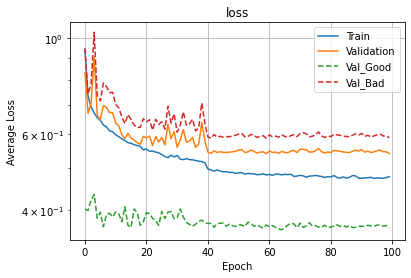

Saved model to ../results/models/foe_cnn_e1d3eefedd01a0383c6c5547367e178d_f4.pt
FINAL RESULTS:
	Train good rmse: 6.1° ± 0.2°
	Train bad rmse: 9.2° ± 0.1°
	Val good rmse: 5.7° ± 1.0°
	Val bad rmse: 10.8° ± 0.7°



In [5]:
# configure fingerprint patch dataset in folds and run the experiments

fpd_gd = FOEFingerprintDataset(dataset_dir, 'good')
fpd_gd.set_split_indices(splits_dir, split_id, num_folds)

fpd_bd = FOEFingerprintDataset(dataset_dir, 'bad')
fpd_bd.set_split_indices(splits_dir, split_id, num_folds)

RMSE = []
for fold_id in range(num_folds):
    print('* '*40)
    print('Experiments for fold {} starts...'.format(fold_id))

    ae_train_loader = train_loader = val_loader = None
    val_loader_gd = val_loader_bd = None

    (ae_train_loader, train_loader, val_loader_gd, val_loader_bd,
     val_loader) = create_dataloaders(fpd_gd, fpd_bd, fold_id, NUM_WORKERS,
                                      use_gpu, args)
    num_val_gd = len(val_loader_gd.dataset)
    num_val_bd = len(val_loader_bd.dataset)

    encoder = None
    if approach == 'ae_mlp':
        ae, metrics = init_model('ae', models_dir, file_id, fold_id,
                                 device, args)
        n_epochs = ae_num_epochs - len(metrics.data['train_loss'])
        loss_fn = torch.nn.MSELoss(reduction='sum')
        optimizer = optim.Adam(ae.parameters(), lr=ae_learning_rate)
        scheduler_array = [int(0.7 * ae_num_epochs),
                           int(0.9 * ae_num_epochs)]
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                   scheduler_array,
                                                   gamma=0.1)
        for e in range(1, n_epochs+1):
            train_loss = train_epoch(ae, ae_train_loader, loss_fn, optimizer,
                                     is_ae=True)
            val_loss_gd = val_epoch(ae, val_loader_gd, loss_fn, is_ae=True)
            val_loss_bd = val_epoch(ae, val_loader_bd, loss_fn, is_ae=True)
            val_loss = ((num_val_gd * val_loss_gd + num_val_bd * val_loss_bd) /
                        (num_val_gd + num_val_bd))
            scheduler.step()

            print('EPOCH {}/{}\tLOSS for train/good val/bad val: '
                  '{:.3f} / {:.3f} / {:.3f} / {:.3f}'
                  .format(e, n_epochs, train_loss, val_loss,
                          val_loss_gd, val_loss_bd))

            metrics.append(train_loss, val_loss, val_loss_gd, val_loss_bd)
        metrics.plot()
        ae.plot_outputs(val_loader_gd.dataset, 5)
        ae.plot_outputs(val_loader_bd.dataset, 5)
        if n_epochs > 0:
            save_model(ae)
            metrics.save()
        encoder = ae.encoder

        model, metrics = init_model('mlp', models_dir, file_id, fold_id,
                                    device, args)
        loss_fn = torch.nn.CrossEntropyLoss(reduction='sum').to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler_array = [int(0.4 * num_epochs),
                           int(0.75 * num_epochs)]
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, scheduler_array,
                                                   gamma=0.1)
    elif approach == 'cnn':
        model, metrics = init_model('cnn', models_dir, file_id, fold_id,
                                    device, args)
        loss_fn = torch.nn.CrossEntropyLoss(reduction='sum').to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler_array = [int(0.4 * num_epochs),
                           int(0.75 * num_epochs)]
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, scheduler_array,
                                                   gamma=0.1)
    else:
        raise Exception('The "approach" parameter should'
                        ' either be "ae_mlp" or "cnn"!')

    estimator = None
    if num_classes > 1:
        estimator = FOEOrientation.radians_from_marginalization

    n_epochs = num_epochs - len(metrics.data['train_loss'])
    for e in range(1, n_epochs+1):
        results = FOEResults()
        results.set_fold(fold_id)

        train_loss = train_epoch(model, train_loader, loss_fn, optimizer,
                                 encoder=encoder, results=results)
        val_loss_gd = val_epoch(model, val_loader_gd, loss_fn,
                                encoder=encoder, results=results)
        val_loss_bd = val_epoch(model, val_loader_bd, loss_fn,
                                encoder=encoder, results=results)
        val_loss = ((num_val_gd * val_loss_gd + num_val_bd * val_loss_bd) /
                    (num_val_gd + num_val_bd))

        metrics.append(train_loss, val_loss, val_loss_gd, val_loss_bd)
        scheduler.step()

        print('EPOCH {}/{}\tLOSS for train/good val/bad val:\t'
              '{:.3f} / {:.3f} / {:.3f} / {:.3f}'
              .format(e, n_epochs, train_loss, val_loss,
                      val_loss_gd, val_loss_bd))

        if e % 10 == 1 or e == n_epochs:
            rmse_val = results.compute_classification_rmse(fold_id, estimator)
            rmse_val = [rmse / np.pi * 180 for rmse in rmse_val]
            print('RMSE for good train/bad train good val/bad val:\t\t'
                  '{:3.1f}° / {:3.1f}° / {:3.1f}° / {:3.1f}°'
                  ''.format(*rmse_val))

            if num_classes > 1:
                acc_val = results.compute_classification_acc(fold_id)
                acc_val = [acc * 100 for acc in acc_val]
                print('ACC for good train/bad train good val/bad val:\t\t'
                      '{:3.1f}% / {:3.1f}% / {:3.1f}% / {:3.1f}%'
                      ''.format(*acc_val))
    metrics.plot()
    if n_epochs > 0:
        save_model(model)
        metrics.save()
    else:
        results = FOEResults()
        results.set_fold(fold_id)
        train_loss = val_epoch(model, train_loader, loss_fn,
                               encoder=encoder, results=results, is_tr=True)
        val_loss_gd = val_epoch(model, val_loader_gd, loss_fn,
                                encoder=encoder, results=results)
        val_loss_bd = val_epoch(model, val_loader_bd, loss_fn,
                                encoder=encoder, results=results)
        val_loss = ((num_val_gd * val_loss_gd + num_val_bd * val_loss_bd) /
                    (num_val_gd + num_val_bd))

        print('Final LOSS for train/good val/bad val:\t'
              '{:.3f} / {:.3f} / {:.3f} / {:.3f}'
              .format(train_loss, val_loss, val_loss_gd, val_loss_bd))

        rmse_val = results.compute_classification_rmse(fold_id, estimator)
        rmse_val = [rmse / np.pi * 180 for rmse in rmse_val]
        print('RMSE for good train/bad train good val/bad val:\t\t'
              '{:3.1f}° / {:3.1f}° / {:3.1f}° / {:3.1f}°'.format(*rmse_val))

        if num_classes > 1:
            acc_val = results.compute_classification_acc(fold_id)
            acc_val = [acc * 100 for acc in acc_val]
            print('ACC for good train/bad train good val/bad val:\t\t'
                  '{:3.1f}% / {:3.1f}% / {:3.1f}% / {:3.1f}%'.format(*acc_val))
    RMSE.append(rmse_val)

RMSE_mean = np.array(RMSE).mean(0)
RMSE_std = np.array(RMSE).std(0)

print('FINAL RESULTS:\n\t'
      'Train good rmse: {:.1f}° ± {:.1f}°\n\t'
      'Train bad rmse: {:.1f}° ± {:.1f}°\n\t'
      'Val good rmse: {:.1f}° ± {:.1f}°\n\t'
      'Val bad rmse: {:.1f}° ± {:.1f}°\n'
      .format(RMSE_mean[0], RMSE_std[0], RMSE_mean[1], RMSE_std[1],
              RMSE_mean[2], RMSE_std[2], RMSE_mean[3], RMSE_std[3]))